<a href="https://colab.research.google.com/github/SudilHasitha/LISA_CNN_ExplainerV3/blob/master/LISA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd '/content/drive/MyDrive/Research/'

/content/drive/MyDrive/Research


In [ ]:
# import libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML

In [ ]:
import skimage.color
import skimage.filters
import skimage.io
import numpy as np

def customized_mask(img_sk):
  # convert to gray scale before applying otsu
  img_sk = skimage.color.rgb2gray(img_sk)
  blur = skimage.filters.gaussian(img_sk, sigma=1.5)
  t = skimage.filters.threshold_otsu(blur)
  mask = blur < t
  # use the mask to select the "interesting" part of the image
  sel = np.zeros_like(img_sk)
  sel[mask] = img_sk[mask]
  # convert back to rgb to match with CNN input layers
  sel = skimage.color.gray2rgb(sel)
  return sel/255.

In [ ]:
train_list_filenames=[] # get image files
train_list_labels=[] # get corresponding names

dstpath='/content/drive/MyDrive/Research/train' # path to the train Data set
test_df = pd.read_csv('/content/drive/MyDrive/Research/test.txt', sep=" ", header=None) # get the txt as dataframe
test_df.columns=['patient id', 'filenames', 'labels', 'data source' ] # assign column names to data frame
test_df=test_df.drop(['patient id', 'data source'], axis=1 ) # dropped the data columns
print (test_df.head()) # print the first 5
print("------------------------------------------------------------")

train_txt= open("/content/drive/MyDrive/Research/train.txt","r") 
train_list=train_txt.readlines() # train data is access by the handler
for line in train_list:
    split=line.split(' ')   # split the line with spaces 
    if len(split)>4: # if no of elements in the split list is > than 4       
        fname=os.path.join(dstpath, split[2])  # access the image in train data      
        label=split[3] # access the lable in text 
    else:        
        fname=os.path.join(dstpath, split[1]) 
        label=split[2]
    train_list_filenames.append(fname) # append the image path
    train_list_labels.append(label) # append the label name

# create two series to store the file names and lables
Ftrseries=pd.Series(train_list_filenames, name='filenames') 
Ltrseries=pd.Series(train_list_labels, name='labels')

# create dataframes from the series
df=pd.concat([Ftrseries, Ltrseries], axis=1)
print (df.head()) # print df
balance=df['labels'].value_counts() # get the summary of content
print (balance)

                                   filenames    labels
0  MIDRC-RICORD-1C-419639-003251-46647-0.png  positive
1  MIDRC-RICORD-1C-419639-001464-39871-0.png  positive
2  MIDRC-RICORD-1C-419639-000918-78965-0.png  positive
3  MIDRC-RICORD-1C-419639-003318-64285-0.png  positive
4  MIDRC-RICORD-1C-419639-001015-81591-0.png  positive
------------------------------------------------------------
                                           filenames    labels
0  /content/drive/MyDrive/Research/train/ARDSSeve...  negative
1  /content/drive/MyDrive/Research/train/acute-re...  negative
2  /content/drive/MyDrive/Research/train/acute-re...  negative
3  /content/drive/MyDrive/Research/train/ards-sec...  negative
4  /content/drive/MyDrive/Research/train/pneumocy...  negative
negative    13793
positive     2158
Name: labels, dtype: int64


In [ ]:
file_count = 2158 # assign the variable to least available class
samples = [] # get the samples to array
for category in df['labels'].unique(): # get the uniques names    
    category_slice = df.query("labels == @category") # assign the names to the list
    samples.append(category_slice.sample(file_count, replace=False,random_state=1)) # get a sample of 2158
df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True) # put the samples do df removing the existing df
print (  df['labels'].value_counts()) # check to see each class has 200 samples
print (len(df))

negative    2158
positive    2158
Name: labels, dtype: int64
4316


In [ ]:
tsplit=.9 # 90% for trainning 
train_df, valid_df=train_test_split(df, train_size=tsplit, shuffle=True, random_state=123) # train and validation test
height=224 
width=224
channels=3
batch_size=60
img_shape=(height, width, channels) # create image shape tuple 
img_size=(height, width) # create tuple for image size
train_split=.9 
train_df, valid_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
print ('train samples: ', len(train_df), '  test samples: ', len(test_df), ' validation samples', len(valid_df)) # print size of training test and validate size


def scalar(img):
    return img/127.5-1  # scale pixel between -1 and +1

gen=ImageDataGenerator(preprocessing_function=customized_mask)

# generate training dataset        
train_gen=gen.flow_from_dataframe( train_df, x_col='filenames', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=batch_size)

length= len(test_df) # determine test batch size and test steps such that test_batch_size X test_steps = number of test samples
# get the test batch size
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=batch_size],reverse=True)[0]
print(test_batch_size)
# get the test step  
test_steps=int(length/test_batch_size) 
print(test_steps)
# convert the training dataset and validation dataset to appropriate sizes to CNN 
test_gen=gen.flow_from_dataframe( test_df, '/content/drive/MyDrive/Research/test', x_col='filenames', y_col='labels', target_size=img_size,
                                 class_mode='categorical',color_mode='rgb', shuffle=False, batch_size=test_batch_size)
valid_gen=gen.flow_from_dataframe( valid_df, x_col='filenames', y_col='labels', target_size=img_size,
                                 class_mode='categorical',color_mode='rgb', shuffle=False, batch_size=test_batch_size)

train samples:  3884   test samples:  400  validation samples 432
Found 3521 validated image filenames belonging to 2 classes.
50
8
Found 400 validated image filenames belonging to 2 classes.
Found 397 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 363 invalid image filename(s) in x_col="filenames". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 35 invalid image filename(s) in x_col="filenames". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [ ]:
model_inception_v2_masked_v4 = tf.keras.models.load_model("model_InceptionV2_completed_masked_v5")

In [ ]:
# create a function to load and prepare images
def load_and_prep_image(filename,img_shape=224,scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshape into specified shape (img_shape,img_shape,3).

  Args:
    filename (str): path to target image
    image_shape (int): height/ weight dimension of the target image size
    scale (bool): scale pixel values from 0-255 to 0-1 or not

  Returns: 
    Image tensor of shape (img_shape,img_shape,3)

  """
  # read the image
  img = tf.io.read_file(filename)

  # decode image into tensor
  img = tf.io.decode_image(img,channels=3) # hardcode for 3 channels to be compatible despite of the image type

  # resize the image
  img = tf.image.resize(img,[img_shape,img_shape])

  # Scale Y/N
  if scale:
    return img/255.
  else:
    return img

In [ ]:
test1 = "MIDRC-RICORD-1C-419639-003251-46647-0.png"
a="MIDRC-RICORD-1C-419639-001699-69345-0.png" # false negative
b="MIDRC-RICORD-1C-419639-001629-03737-0.png" # false negative
c="MIDRC-RICORD-1C-419639-001603-23454-0.png" # 4 correct
d="MIDRC-RICORD-1C-419639-002895-42704-0.png"
e="MIDRC-RICORD-1C-419639-003186-86346-0.png"

f="MIDRC-RICORD-1C-419639-003027-36839-0.png"
g="MIDRC-RICORD-1C-419639-003191-84953-0.png"
h="MIDRC-RICORD-1C-419639-003157-67493-0.png"
i="MIDRC-RICORD-1C-419639-000235-89929-0.png"
j="MIDRC-RICORD-1C-419639-000538-40522-0.png"
k="MIDRC-RICORD-1C-419639-001222-46073-0.png"
l="MIDRC-RICORD-1C-419639-001699-69345-0.png"
m="MIDRC-RICORD-1C-419639-002472-45590-0.png" # give correct in model 5 and 4 model 5 anchor
illus="MIDRC-RICORD-1C-419639-000002-10161-0.png"
neg="1565fd6c-9432-454a-87e4-937fd5ad5b60.png"

(-0.5, 223.5, 223.5, -0.5)

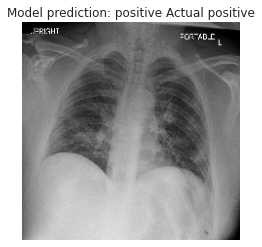

In [ ]:
row = test_df.loc[test_df['filenames'] == m]
filepath = str("/content/drive/MyDrive/Research/test/") + row["filenames"].values[0]
class_name= str(row["labels"].values[0])

class_names=["negative","positive"]

img = load_and_prep_image(filepath,scale=True)

pred_prob_4 = model_inception_v2_masked_v4.predict(tf.expand_dims(img,axis=0))
pred_class_4 = class_names[pred_prob_4[0].argmax()]

# pred_prob_5 = model_inception_v2_masked_v5.predict(tf.expand_dims(img,axis=0))
# pred_class_5 = class_names[pred_prob_5[0].argmax()]

plt.title(f'Model prediction: {pred_class_4} Actual {class_name}')
plt.imshow(img)
plt.axis("off")


Try to get the explanation regions from each method = I tried and it works

Superimpose the explanation regions

Take lime explanation region then find intersection with IG.

4C2 = 4x3x2x1/2x2 = 6

Check whether anochor explanations are zero or not 

if not intersect with some other explanation

check lime is empty or not

if not ......



In [ ]:
explanation_list={"Anchor":None,
                  "LIME":None,
                  "IG":None,
                  "SHAP":None}

In [ ]:
def installlibraries():
  !pip install alibi[ray]
  !pip install lime
  !pip install shap

def anchor_explanations(n_segments,compactness,sigma,image,model,segmentation_fn="slic",
                        threshold=.95, p_sample=.5, tau=0.25,image_shape=(224,224,3)):
  
  """
  Anchor explanations are produced
  n_segments: number of segments
  compactness: 
  """
  global explanation_list
  # perform imports
  try:
    from alibi.explainers import AnchorImage
  except:
    installlibraries()
  from alibi.explainers import AnchorImage
  import numpy as np


  predict_fn = lambda x: model.predict(x)
  image = np.array(image)
  #felzenszwalb, slic and quick shift
   # not for felzenszwalb 
  if segmentation_fn == "slic":
    kwargs = {'n_segments': n_segments, 'compactness': compactness, 'sigma': sigma}
    explainer = AnchorImage(predict_fn, image_shape=image_shape, segmentation_fn=segmentation_fn,
                            segmentation_kwargs=kwargs, images_background=None)
  else:
    explainer = AnchorImage(predict_fn, image_shape=image_shape, segmentation_fn=segmentation_fn,
                            images_background=None)
  np.random.seed(0)
  explanation = explainer.explain(image, threshold, p_sample, tau)
  

  fig = plt.figure(figsize=(10, 7))
  # setting values to rows and column variables
  rows = 1
  columns = 2

  fig.add_subplot(rows, columns, 1)
  plt.imshow(explanation.anchor)
  plt.axis('off')
  plt.savefig("AnchorExpalanation.png")

  fig.add_subplot(rows, columns, 2)
  plt.imshow(explanation.segments)
  plt.axis('off')
  plt.savefig("AnchorSegmentation.png")
 

  # if np.any(explanation.anchor>0):
  explanation_list["Anchor"]=explanation.anchor
  return explanation

def LIME_explanations(model,image,prediction,class_name=None,positive_only=True,num_features=10000,
                      hide_rest=False,min_weight=0.1,top_labels=1, hide_color=None, num_samples=None):
  """
  model:CNN
  image:The image that we want LIME to explain.
  prediction:Your image classier prediction.
  class_name:Real Prediction if avaiable
  top_labels:The number of labels that you want LIME to show. If it’s 3, then it will only show the top 3 labels with highest probabilities and ignore the rest.
  num_samples:to determine the amount of artificial data points similar to our input that will be generated by LIME.
  hide_color: is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels. 
             (in the representation used by inception model, 0 means gray)
  positive_only:Bool show only the positive part
  num_features:Number of features in the positive need to show
  hide_rest:Bool rest of the image need to hide or not
  min_weight: such as 0.1 to be taken as value for the prediction
  """

  global explanation_list

  try:
    import lime
  except:
    installlibraries()
  import lime
  from lime import lime_image
  from skimage.segmentation import mark_boundaries
  
  image=np.array(image)
  explainer = lime_image.LimeImageExplainer(random_state=42)

  explanation = explainer.explain_instance(image, model.predict, hide_color, num_samples)
  
  
  plt.title(f"Prediction: {prediction} Actual: {class_name}")
  
  plt.imshow((image * 255).astype(np.uint8))
  
  if positive_only==False and hide_rest==False:
      image, mask = explanation.get_image_and_mask(model.predict(image.reshape((1,224,224,3))).argmax(axis=1)[0],positive_only=positive_only,
                                                    hide_rest=hide_rest,num_features=num_features,min_weight=min_weight)
  else:
      image, mask = explanation.get_image_and_mask(model.predict(image.reshape((1,224,224,3))).argmax(axis=1)[0],positive_only=positive_only,
                                                   hide_rest=hide_rest,num_features=num_features,min_weight=min_weight)
  plt.axis('off')
  plt.imshow(mark_boundaries(image, mask))
  plt.savefig("LimeExplanation.png")

  explanation_list["LIME"]=mask
  

def integrated_Gradients(model,img,prediction,class_name,Scale_Factor=1,n_steps=20,internal_batch_size=20,Random_baseline=False,
                         method = "gausslegendre"):

  global explanation_list
  try:
    from alibi.explainers import IntegratedGradients
  except:
    installlibraries()
  from alibi.explainers import IntegratedGradients
  from alibi.utils.visualization import visualize_image_attr
  import tensorflow as tf
  import numpy as np
  from PIL import Image
  import tensorflow.python.ops.numpy_ops.np_config as np_config
  np_config.enable_numpy_behavior()
  tf.executing_eagerly()


  
  
  ig  = IntegratedGradients(model,n_steps=n_steps,method=method,internal_batch_size=internal_batch_size)
  image_copy = img
  
  instance = np.expand_dims(img, axis=0)
  if Random_baseline:
    baselines = np.random.random_sample(instance.shape)
  else:
    baselines=None

  predictions = model(instance).numpy().argmax(axis=1)

  
  image = np.array(img)
  explanation = ig.explain(instance,baselines=baselines,target=predictions)
  
  attrs = explanation.attributions[0]
  
  # scaling attribute values
  attrs = attrs.squeeze()*Scale_Factor

  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
  plt.axis('off')

  visualize_image_attr(attr=None, original_image=(image * 255).astype(np.uint8), method='original_image',
                    title=f'Prediction {prediction}, Actual {class_name}', plt_fig_axis=(fig, ax[0]), use_pyplot=False);

  visualize_image_attr(attr=attrs.squeeze(), original_image=image, method='blended_heat_map',
                    sign='all', show_colorbar=True, title='Overlaid Attributions',
                    plt_fig_axis=(fig, ax[1]), use_pyplot=True);
  fig.savefig("IGExplanation.png")
 
  explanation_list["IG"]=attrs
  

# (img * 255).astype(np.uint8)
def Shape_Gradient_Explainer(model,images_list):
  global explanation_list
  import time
  s =time.time()
  try:
    import shap
  except:
    installlibraries()
  import shap
  import time
  # get the length of the image list
  k = len(images_list)

  # since we have two inputs we pass a list of inputs to the explainer
  explainer = shap.GradientExplainer(model,images_list)

  # we explain the model's predictions on the first three samples of the test set
  shap_values = explainer.shap_values(images_list[0:k])
  
  print(len(shap_values))
  shap.image_plot(shap_values, images_list[0:k],width=60,aspect=0.1,hspace=0.1,show=False)
  plt.savefig("SHAPExplanation.png")
  explanation_list["SHAP"]=shap_values
  e =time.time()
  print(f"Run time is {(e-s)/60}")

     |████████████████████████████████| 387 kB 28.7 MB/s 
     |████████████████████████████████| 22.3 MB 1.5 MB/s 
     |████████████████████████████████| 3.1 MB 48.7 MB/s 
     |████████████████████████████████| 458.3 MB 2.5 kB/s 
     |████████████████████████████████| 54.7 MB 22 kB/s 
     |████████████████████████████████| 118 kB 76.3 MB/s 
     |████████████████████████████████| 28.0 MB 47 kB/s 
     |████████████████████████████████| 462 kB 36.8 MB/s 
     |████████████████████████████████| 5.6 MB 35.6 MB/s 
     |████████████████████████████████| 1.3 MB 39.1 MB/s 
     |████████████████████████████████| 59 kB 7.7 MB/s 
     |████████████████████████████████| 596 kB 41.5 MB/s 
     |████████████████████████████████| 3.3 MB 15 kB/s 
     |████████████████████████████████| 895 kB 36.0 MB/s 
  Created wheel for spacy-lookups-data: filename=spacy_lookups_data-0.1.0-py2.py3-none-any.whl size=28052157 sha256=51032e1c6fa2f3df578f107ca01cd875150b3a0e0b14fc4ad5b51ce81d8f3457
  Stored in 

     |████████████████████████████████| 275 kB 28.1 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=0f46d289cd41110b06aebba47635a8533410743cba178cc646be01a9e2e62dd6
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime
     |████████████████████████████████| 371 kB 21.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shap: filename=shap-0.40.0-cp37-cp37m-linux_x86_64.whl size=509235 sha256=f6c16c044e9c51d5442a737f9ab6ef78894ba1a8aa46b1175245f7cbccb42359
  Stored in directory: /root/.cache/pip/wheels/ec/35/84/e304841ac4b910bc95fe9a6e5302eb2507b4333728851dcbfb
Successfully built shap


/usr/local/lib/python3.7/dist-packages/redis/connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
  warnings.warn(msg)


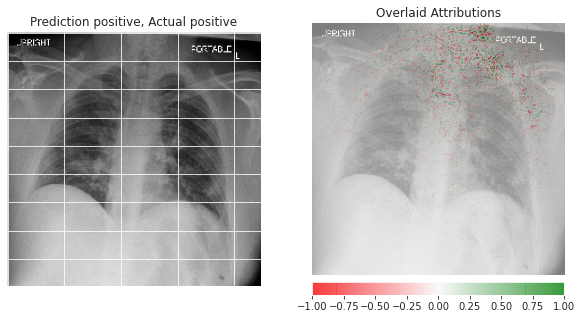

In [ ]:
integrated_Gradients(model_inception_v2_masked_v4,img,pred_class_4,class_name)

In [ ]:
LIME_explanations(model_inception_v2_masked_v4,img,pred_class_4,class_name,min_weight=0.05)

ValueError: ignored

e.g., 0.01, 0.1, 1, 10, 100, for compactness

n_segments=15,compactness=20 sigma=0.5

In [ ]:
aexp_4=anchor_explanations(7,20,0.5,img,model_inception_v2_masked_v4,"slic")

In [ ]:
img_list=[]
prediction_list=[]
for i in range(2):
  row = test_df.sample()
  filepath = str("/content/drive/MyDrive/Research/test/") + row["filenames"].values[0]
  imgf = load_and_prep_image(str(filepath),scale=True)
  img_list.append(imgf)
  
img_list.append(img)
img_list = np.array(img_list)  

In [ ]:
Shape_Gradient_Explainer(model_inception_v2_masked_v4,img_list)

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

In [ ]:
def FFT(img):
  # fft to convert the image to freq domain 
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # fft to convert the image to freq domain 
  f = np.fft.fft2(img)

  # shift the center
  fshift = np.fft.fftshift(f)

  rows, cols = img.shape
  crow,ccol = int(rows/2) , int(cols/2)

  # remove the low frequencies by masking with a rectangular window of size 60x60
  # High Pass Filter (HPF)
  rows, cols = img.shape
  crow, ccol = int(rows / 2), int(cols / 2)

  mask = np.ones((rows, cols), np.uint8)
  r = 10
  center = [crow, ccol]
  x, y = np.ogrid[:rows, :cols]
  mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= r*r
  mask[mask_area] = 0
  fshift = fshift * mask

  

  # shift back (we shifted the center before)
  f_ishift = np.fft.ifftshift(fshift)

  # inverse fft to get the image back 
  img_back = np.fft.ifft2(f_ishift)

  img_back = np.abs(img_back)

  magnitude_spectrum = 20*np.log(np.abs(fshift))
  print(magnitude_spectrum.shape)

  from matplotlib.pyplot import figure
  figure(num=None, figsize=(18, 16), dpi=80, facecolor='w', edgecolor='k')
  plt.subplot(141),plt.imshow(magnitude_spectrum, cmap = 'gray')
  plt.title('magnitude_spectrum after filtering'), plt.xticks([]), plt.yticks([])
  plt.subplot(142),plt.imshow(img, cmap = 'gray')
  plt.title('Input Image'), plt.xticks([]), plt.yticks([])
  plt.subplot(143),plt.imshow(img_back, cmap = 'gray')
  plt.title('Image after HPF'), plt.xticks([]), plt.yticks([])
  plt.subplot(144),plt.imshow(img_back)
  plt.title('LISA Explanation Boundary'), plt.xticks([]), plt.yticks([])

  plt.show()


In [ ]:
FFT(np.array(img,dtype=np.float32))

In [ ]:
from PIL import Image
from matplotlib import cm
import cv2
from google.colab.patches import cv2_imshow
def LISA(input_image):
  
  Anchor=explanation_list.get("Anchor")
  LIME=explanation_list.get("LIME")
  IG=explanation_list.get("IG")
  SHAP=explanation_list.get("SHAP")

  
  # # SHAP
  # Convert SHAP to numpy array
  SHAP_np = np.array(SHAP)
  
  # Access the shaply value of explained image
  # SHAP_np[0][2]
  SHAP_np_target = SHAP_np[0][0]
 
  # extract positive shape values
  SHAP_np_target_positive = np.where(SHAP_np_target>0,SHAP_np_target,0)
  SHAP_np_target_positive_replace = SHAP_np_target_positive.copy()
  # get the shape value if any present in R or B pixcel line which are positive shapley values and replace with G
  SHAP_np_target_positive_replace = np.where(((SHAP_np_target_positive_replace[...,0]>0).any() | 
                                              (SHAP_np_target_positive_replace[...,1]>0).any() | 
                                              (SHAP_np_target_positive_replace[...,2]>0).any())
                                             ,SHAP_np_target_positive_replace[...,1],0)
 

  # using opencv
  # convert to cv2 gray scale images
  im_shap = np.array(SHAP_np_target_positive_replace * 255, dtype = np.uint8)
  threshed_shap = cv2.adaptiveThreshold(im_shap, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 3, 0)
  
  # Add colour to shap
  img_shap = np.zeros((224,224,3),dtype = np.float32)
  img_shap[:,:,0]=threshed_shap* 255./255. 
  img_shap[:,:,1]=threshed_shap* 0/255.
  img_shap[:,:,2]=threshed_shap* 0/255.
 

  # Apply green color mask to lime explanations
  im_lime = np.array(LIME * 255, dtype = np.uint8)
  # create 3 channel image
  img_lime = np.zeros((224,224,3),dtype = np.float32)
  img_lime[:,:,0]=im_lime*0/255.
  img_lime[:,:,1]=im_lime*255./255.
  img_lime[:,:,2]=im_lime*0/255.
  
 
  im_IG=np.array(IG, dtype = np.uint8)
  gray_IG = cv2.cvtColor(im_IG, cv2.COLOR_BGR2GRAY)
   # create 3 channel image
  img_IG = np.zeros((224,224,3),dtype = np.float32)
  img_IG[:,:,0]=gray_IG*0/255.
  img_IG[:,:,1]=gray_IG*0/255.
  img_IG[:,:,2]=gray_IG*1.
  
  #Anchor
  Anchor_np = np.array(Anchor, dtype = np.uint8)
  gray_Anchor = cv2.cvtColor(Anchor_np, cv2.COLOR_BGR2GRAY)
  threshed_anchor = cv2.adaptiveThreshold(gray_Anchor, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 3, 0)
  
  img_anchor = np.zeros((224,224,3),dtype = np.float32)
  img_anchor[:,:,0]=threshed_anchor*255./255.
  img_anchor[:,:,1]=threshed_anchor*223./255.
  img_anchor[:,:,2]=threshed_anchor*0/255.

  mask = img_shap + img_lime + img_IG  + img_anchor
  # normalize the mask
  img_mask = (mask/np.float(np.max(mask)) )*255.

  

  # open cv alpha blending with weights
  # convert input image to array
  input_image_array = np.array(input_image*255.,dtype=np.float32)

  dst = cv2.addWeighted(input_image_array, 1, img_mask, 0.8, 0)
  dst_I = cv2.bitwise_and(input_image_array,img_mask,input_image_array)
  print(input_image.shape)
  # cv2_imshow(input_image_array)
  FFT(input_image_array)

  cv2_imshow(dst)
  cv2_imshow(dst_I)
LISA(img)

In [ ]:
from PIL import Image
from matplotlib import cm
import cv2
from google.colab.patches import cv2_imshow
def LISA():
  
  Anchor=explanation_list.get("Anchor")
  LIME=explanation_list.get("LIME")
  IG=explanation_list.get("IG")
  SHAP=explanation_list.get("SHAP")

  
  # '''              # SHAP
  # Convert SHAP to numpy array
  SHAP_np = np.array(SHAP)
  # print("SHAP np shape ",SHAP_np.shape)

  # Access the shaply value of explained image
  # SHAP_np[0][2]
  SHAP_np_target = SHAP_np[0][2]
  # print("SHAP np traget shape ",SHAP_np_target.shape)
  # show the target shap
  # print("Maximum value in shape ",np.max(SHAP_np_target))
  # print("Minimum value in shape ",np.min(SHAP_np_target))

  # extract positive shape values
  SHAP_np_target_positive = np.where(SHAP_np_target>0,SHAP_np_target,0)
  # 123 the value
  SHAP_np_target_positive_replace = SHAP_np_target_positive.copy()
  # get the shape value if any present in R or B pixcel line which are positive shapley values and replace with G
  SHAP_np_target_positive_replace = np.where(((SHAP_np_target_positive_replace[...,0]>0).any() | 
                                              (SHAP_np_target_positive_replace[...,1]>0).any() | 
                                              (SHAP_np_target_positive_replace[...,2]>0).any())
                                             ,SHAP_np_target_positive_replace[...,1],0)
  # plt.imshow(SHAP_np_target_positive_replace)
  # stacked_SHAP = np.stack((SHAP_np_target_positive_replace,)*3, axis=-1)
  # print("Shape of stacked SHAP",stacked_SHAP.shape)
  # plt.imshow(stacked_SHAP[0])
  # '''

  # '''LIME
  # convert lime to 3 channel
  # stacked_LIME = np.stack((LIME*255.,)*3, axis=-1)
  # print("stacked_LIME shape ",LIME.shape)
  # plt.imshow((stacked_LIME * 255).astype(np.uint8))
  # plt.imshow(stacked_LIME.astype('uint'))
  # plt.imshow(LIME)
  # print("Maximum value in LIME ",np.max(LIME))
  # '''
  # IG
  # plt.imshow(np.squeeze(IG))
  # print("Maximum value in LIME ",np.max(IG))

  # Anchor 
  # print("Anchor shape ",Anchor.shape)
  # plt.imshow(Anchor)

  # Intersecting the explanations

  # Convert the array to Pillow image
  # PIL_image_Anchor = Image.fromarray(np.uint8(Anchor)).convert('L')
  # PIL_image_SHAP = Image.fromarray(np.uint8(SHAP_np_target_positive_replace*255)).convert('L')
  # PIL_image_LIME = Image.fromarray(np.uint8(LIME)).convert('L')
  # PIL_image_IG = Image.fromarray(np.uint8(IG)).convert('L')
  
  # # take the image from user
  # input_img = np.array(img)
  # PIL_image_img = Image.fromarray(np.uint8(input_img*255)).convert('RGB')
  # plt.imshow(PIL_image_img)

  # using opencv
  # convert to cv2 gray scale images
  im_shap = np.array(SHAP_np_target_positive_replace * 255, dtype = np.uint8)
  threshed_shap = cv2.adaptiveThreshold(im_shap, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 3, 0)
  # cv2_imshow(threshed_shap)
  
  # Add colour to shap
  img_shap = np.zeros((224,224,3),dtype = np.float32)
  img_shap[:,:,0]=threshed_shap
  img_shap[:,:,1]=threshed_shap
  img_shap[:,:,2]=threshed_shap
  # cv2_imshow(img_shap)

  # print(img_shap.shape)
  # Convert RGB to HSV
  HSV_SHAP = cv2.cvtColor(img_shap, cv2.COLOR_RGB2HSV)

  # change white color to red for shap
  sensitivity = 15
  lower_white = np.array([0,0,255-sensitivity])
  upper_white = np.array([255,sensitivity,255])

  # Mask image to only select white
  mask=cv2.inRange(HSV_SHAP,lower_white,upper_white)  
  # Change image to red where we found white
  HSV_SHAP[mask>0]=(255,0,0)
  # RGB_SHAP = cv2.cvtColor(HSV_SHAP, cv2.COLOR_HSV2RGB)
  cv2_imshow(HSV_SHAP)

  # Apply green color mask to lime explanations
  im_lime = np.array(LIME * 255, dtype = np.uint8)
  print("im_lime",im_lime.shape)
  # create 3 channel image
  img_lime = np.zeros((224,224,3),dtype = np.float32)
  img_lime[:,:,0]=im_lime
  img_lime[:,:,1]=im_lime
  img_lime[:,:,2]=im_lime
  # Convert RGB to HSV
  HSV_lime = cv2.cvtColor(img_lime, cv2.COLOR_RGB2HSV)
  # Mask image to only select white
  mask=cv2.inRange(HSV_lime,lower_white,upper_white)  
  # Change image to red where we found brown
  HSV_lime[mask>0]=(0,255,0)
  # RGB_SHAP = cv2.cvtColor(HSV_SHAP, cv2.COLOR_HSV2RGB)
  cv2_imshow(HSV_lime)
  # cv2_imshow(im_lime)

  # print(np.max(IG))
  # print(type(LIME))
  
  # IG_norm=IG/np.linalg.norm(IG)
  # print(np.max(IG_norm))
  im_IG=np.array(IG, dtype = np.uint8)
  gray_IG = cv2.cvtColor(im_IG, cv2.COLOR_BGR2GRAY)
   # create 3 channel image
  img_IG = np.zeros((224,224,3),dtype = np.float32)
  img_IG[:,:,0]=gray_IG
  img_IG[:,:,1]=gray_IG
  img_IG[:,:,2]=gray_IG
  # Convert RGB to HSV
  HSV_IG = cv2.cvtColor(img_IG, cv2.COLOR_BGR2HSV)
  # Mask image to only select white
  mask=cv2.inRange(HSV_IG,lower_white,upper_white)  
  # Change image to blue where we found white
  HSV_IG[mask>0]=(255,0,0)
  # RGB_SHAP = cv2.cvtColor(HSV_SHAP, cv2.COLOR_HSV2RGB)
  cv2_imshow(HSV_IG)

  # gImg_IG = cv2.cvtColor(gImg_IG, cv2.COLOR_BGR2GRAY)
  # print("ig_s",gImg_IG.shape)
  # cv2_imshow(gImg_IG)




  #Anchor
  Anchor_np = np.array(Anchor, dtype = np.uint8)
  gray_Anchor = cv2.cvtColor(Anchor_np, cv2.COLOR_BGR2GRAY)
  threshed_anchor = cv2.adaptiveThreshold(gray_Anchor, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 3, 0)
  
  img_anchor = np.zeros((224,224,3),dtype = np.float32)
  img_anchor[:,:,0]=threshed_anchor
  img_anchor[:,:,1]=threshed_anchor
  img_anchor[:,:,2]=threshed_anchor
  
  # Convert RGB to HSV
  HSV_Anchor = cv2.cvtColor(img_anchor, cv2.COLOR_RGB2HSV)
  # change white color to red for shap
  sensitivity = 15
  lower_white = np.array([0,0,255-sensitivity])
  upper_white = np.array([255,sensitivity,255])

  # Mask image to only select white
  mask=cv2.inRange(HSV_Anchor,lower_white,upper_white)  
  # Change image to red where we found white
  HSV_Anchor[mask>0]=(255,223,0)
  # cv2_imshow(HSV_Anchor)
  mask = HSV_IG  + HSV_lime + HSV_SHAP + HSV_Anchor


  # print(gray_Anchor.shape)
  # mask2 = im_lime+Anchor
  cv2_imshow(mask)
  # cv2_imshow(mask2)
LISA()

**Unified Approach**

This is a unified approach which use LIME,Integrated Gradients,SHAP and Anchors for superimpose the explanations in distinct colours to give explanations of decisions made by the CNNs

In [ ]:
from PIL import Image
from matplotlib import cm
import cv2
from google.colab.patches import cv2_imshow
def LISA(input_image):
  
  Anchor=explanation_list.get("Anchor")
  LIME=explanation_list.get("LIME")
  IG=explanation_list.get("IG")
  SHAP=explanation_list.get("SHAP")

  
  # # SHAP
  # Convert SHAP to numpy array
  SHAP_np = np.array(SHAP)
  
  # Access the shaply value of explained image
  # SHAP_np[0][2] # second array value should be a variable
  SHAP_np_target = SHAP_np[0][0]
 
  # extract positive shape values
  SHAP_np_target_positive = np.where(SHAP_np_target>0,SHAP_np_target,0)
  SHAP_np_target_positive_replace = SHAP_np_target_positive.copy()
  # get the shape value if any present in R or B pixcel line which are positive shapley values and replace with G
  SHAP_np_target_positive_replace = np.where(((SHAP_np_target_positive_replace[...,0]>0).any() | 
                                              (SHAP_np_target_positive_replace[...,1]>0).any() | 
                                              (SHAP_np_target_positive_replace[...,2]>0).any())
                                             ,SHAP_np_target_positive_replace[...,1],0)
 

  # using opencv
  # convert to cv2 gray scale images
  im_shap = np.array(SHAP_np_target_positive_replace * 255, dtype = np.uint8)
  threshed_shap = cv2.adaptiveThreshold(im_shap, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 3, 0)
  
  # Add colour to shap
  img_shap = np.zeros((224,224,3),dtype = np.float32)
  img_shap[:,:,0]=threshed_shap* 255./255. 
  img_shap[:,:,1]=threshed_shap* 0/255.
  img_shap[:,:,2]=threshed_shap* 0/255.
 
  # Apply green color mask to lime explanations
  im_lime = np.array(LIME * 255, dtype = np.uint8)
  # create 3 channel image
  img_lime = np.zeros((224,224,3),dtype = np.float32)
  img_lime[:,:,0]=im_lime*0/255.
  img_lime[:,:,1]=im_lime*255./255.
  img_lime[:,:,2]=im_lime*0/255.
  
 
  im_IG=np.array(IG, dtype = np.uint8)
  gray_IG = cv2.cvtColor(im_IG, cv2.COLOR_BGR2GRAY)
   # create 3 channel image
  img_IG = np.zeros((224,224,3),dtype = np.float32)
  img_IG[:,:,0]=gray_IG*0/255.
  img_IG[:,:,1]=gray_IG*0/255.
  img_IG[:,:,2]=gray_IG*1.
  
  #Anchor
  Anchor_np = np.array(Anchor, dtype = np.uint8)
  gray_Anchor = cv2.cvtColor(Anchor_np, cv2.COLOR_BGR2GRAY)
  threshed_anchor = cv2.adaptiveThreshold(gray_Anchor, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 3, 0)
  
  img_anchor = np.zeros((224,224,3),dtype = np.float32)
  img_anchor[:,:,0]=threshed_anchor*255./255.
  img_anchor[:,:,1]=threshed_anchor*223./255.
  img_anchor[:,:,2]=threshed_anchor*0/255.
  
  
  # union of the explanations
  mask = img_shap + img_lime + img_IG  + img_anchor
  # normalize the mask
  img_mask = (mask/np.float(np.max(mask)) )*255.

  # open cv alpha blending with weights
  # convert input image to array
  input_image_array = np.array(input_image*255.,dtype=np.float32)
  # print(np.max(input_image_array),input_image_array.shape)

  # create the union explanation on input image
  dst = cv2.addWeighted(input_image_array, 1, img_mask, 0.8, 0)

  dst_I = cv2.bitwise_and(input_image_array,img_mask,input_image_array)
  cv2_imshow(dst)
  cv2_imshow(dst_I)
  print(type(dst))
  cv2.imwrite("dst.png",np.array(dst,dtype=np.uint16))
  cv2.imwrite("dst_I.png",np.array(dst_I,dtype=np.uint16))
  cv2.imwrite("dst.png",dst)
LISA(img)

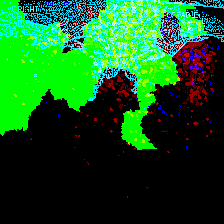

In [ ]:
def fouier_transform(img_mask):
  #Use fouier transformation and create High pass filter to extract the most explantion regions from the LISA
  #Output is a 2D complex array. 1st channel real and 2nd imaginary
  #For fft in opencv input image needs to be converted to float32
  img_mask_gray = cv2.cvtColor(img_mask, cv2.COLOR_BGR2GRAY)
  # img_mask_gray = img_mask
  dft = cv2.dft(np.float32(img_mask_gray), flags=cv2.DFT_COMPLEX_OUTPUT)
  # cv2_imshow(img_mask_gray)

  #Rearranges a Fourier transform X by shifting the zero-frequency 
  #component to the center of the array.
  #Otherwise it starts at the tope left corenr of the image (array)
  dft_shift = np.fft.fftshift(dft)
  plt.plot(dft_shift[:, :, 0][0],np.arange(224))
  plt.plot(dft_shift[:, :, 0][1],np.arange(224))
  # print(dft_shift.shape)

  ##Magnitude of the function is 20.log(abs(f))
  #For values that are 0 we may end up with indeterminate values for log. 
  #So we can add 1 to the array to avoid seeing a warning. 
  dft_shift[:, :, 0][0] = dft_shift[:, :, 0][0] + 1
  dft_shift[:, :, 0][1] = dft_shift[:, :, 0][1] + 1
  magnitude_spectrum = 20 * np.log(cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))
  # cv2_imshow(magnitude_spectrum)
  # Circular  mask, 
  # high value (1) at low frequencies, and 0 at HF region.
  #Can be used for edge detection because low frequencies at center are blocked
  #and only high frequencies are allowed. Edges are high frequency components.
  #Amplifies noise.

  rows, cols = img_mask_gray.shape
  crow, ccol = int(rows / 2), int(cols / 2)

  mask = np.zeros((rows, cols, 2), np.uint8)
  r = 200
  center = [crow, ccol]
  x, y = np.ogrid[:rows, :cols]
  mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= r*r
  mask[mask_area] = 1

  # apply mask and inverse DFT: Multiply fourier transformed image (values)
  #with the mask values. 
  fshift = dft_shift * mask
  fshift = fshift + 1
  #Get the magnitude spectrum (only for plotting purposes)
  fshift_mask_mag = 20 * np.log(cv2.magnitude(fshift[:, :, 0], fshift[:, :, 1]))
  # cv2_imshow(fshift_mask_mag)
  #Inverse shift to shift origin back to top left.
  f_ishift = np.fft.ifftshift(fshift)

  #Inverse DFT to convert back to image domain from the frequency domain. 
  #Will be complex numbers
  img_back = cv2.idft(f_ishift)

  #Magnitude spectrum of the image domain
  img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])
  img_back = cv2.cvtColor(img_back, cv2.COLOR_GRAY2BGR)
  cv2_imshow(img_back)

kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

In [ ]:
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/Research'

In [ ]:
# !cd '/content/drive/MyDrive/Research'

In [ ]:
# !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

In [ ]:
# !mv "/content/chest-xray-pneumonia.zip" "/content/drive/MyDrive/Research/chest-xray-pneumonia.zip"

In [ ]:
# !unzip "/content/drive/MyDrive/Research/chest-xray-pneumonia.zip"

In [ ]:
# !mv "/content/chest_xray" "/content/drive/MyDrive/Research/chest_xray"